In [484]:
# imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

import pandas as pd

from utils.basic_utils import read_dates, load_csvs, csv_load
from utils.pricing import *
from utils.fundamental import filter_cols
import matplotlib as mpl
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:,.3f}'.format

In [485]:
# utility functions
def top_recomm_by_class(pred_df, labels, top_items):
    mask = pred_df.hard_pred_label == pred_df.soft_pred_label
    agree_df = pred_df.loc[mask].drop_duplicates()
    # should add sector and industries, group for allocation insights
    # should add marketcap, beta, etc, group for risk exposure insights
    label_mask = agree_df.soft_pred_label.isin(['bear', 'short', 'long', 'bull'])
    return agree_df.loc[label_mask]\
        .sort_values(by='soft_confidence', ascending=False)\
        .groupby(by='soft_pred_label').head(top_items)\
        .sort_values(by='soft_pred_class')

def pred_distrib(pred_df, count_col):
    dist = pd.value_counts(pred_df[count_col]).to_frame()
    dist['weights'] = dist / dist.sum()
    return dist

def add_desc_stats(df, descriptive_cols):
    
    tickers = df.index
    for k in descriptive_cols.keys():
        desc_df, cols = descriptive_cols[k]['df'], descriptive_cols[k]['columns']
        for c in cols: df.loc[:, c] = tickers.map(desc_df[c].to_dict()).values 

    df = clean_df(df, large_vals, div_cols)

    df.loc[:, 'pegRatio'] = df.forwardPE / (val_df.growthRate * 100)
    df.loc[:, 'size'] = discret_rets(df.marketCap, mkt_cap_cuts, mkt_cap_labels)
        
    return df

def clean_df(df, large_vals, div_cols):
    # convert large values to billions
    df.loc[:, large_vals] = df.loc[:, large_vals] / 10**9
    df.loc[:, div_cols] = df[div_cols].div(df.regularMarketPrice, axis=0)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    return df

def ml_votes_by_class(fndm_dfs, group_mask):
    super_list = []
    for key in fndm_dfs.keys():
        df = fndm_dfs[key]
        super_list.append(
            fndm_dfs[key].loc[:, group_mask].set_index(re_index_col)\
            .rename(columns={group_mask[0]: key}))
    df = pd.concat(super_list, axis=1, sort=False)
    # df.apply(pd.value_counts).loc[fwd_ret_labels].style.background_gradient(cmap='RdYlGn')
    return df.T.apply(pd.value_counts).T

q_group = lambda x, q: x.quantile(q)

ticker_across_mls = lambda ticker: pd.concat(
    [fndm_dfs[key] for key in fndm_dfs.keys()]
    ).set_index('symbol').loc[ticker]

# equal weight ml_confidence
equal_wgt_conf = lambda x: ticker_across_mls(x[0]).loc[:, x[1]].mean()

# take index and class, and calculate a dot product, weighted confidence
score_wgt_conf = lambda x: ticker_across_mls(x[0]).loc[
    :, [x[1], 'model']].set_index('model').T.mul(model_weights).sum(1).iloc[0]

In [486]:
hard_vote, soft_vote = 'hard_pred_label', 'soft_pred_label'

In [487]:
# s3 paths
s3_path = {
    'macro': 'recommend/macro_ML/',
    'px_mom': 'recommend/micro_ML/',
    'fin_data': 'recommend/fdmn_ML-fin_data/',
    'key_statistics': 'recommend/fdmn_ML-key_statistics/',
    'eps_trend': 'recommend/fdmn_ML-eps_trend/',
    'eps_estimates': 'recommend/fdmn_ML-eps_estimates/',
    'day_quote': 'recommend/fdmn_ML-day_quote/',
    'iv_value': 'valuation/waterfall/'
}

In [488]:
# environment variables
bench = '^GSPC'
fwd_ret_labels = ["bear", "short", "neutral", "long", "bull"]
show_classes = ['bear', 'short', 'long', 'bull']
max_rows = 20

key = 'fin_data'
agg_funcs = ['count', 'median', 'max']
mkt_cap_cuts = [0, 0.3, 2, 10, 300, 5000]
mkt_cap_labels = ['micro', 'small', 'mid', 'large', 'mega']

re_index_col = 'symbol'
value_col = 'soft_confidence'
show = ['symbol', 'soft_confidence']
mask_col, class_value = 'soft_pred_label', 'bull'

large_vals = ['marketCap']
div_cols = ['targetMeanPrice', 'targetMedianPrice']

In [489]:
# context / descriptive data
dates = read_dates('quote')
tgt_date = dates[-1] # last date saved in S3

quotes = load_csvs('quote_consol', [tgt_date])
eqty_symbols = quotes[quotes.quoteType == 'EQUITY'].symbol
quotes.set_index('symbol', drop=False, inplace=True)

profile = load_csvs('summary_detail', ['assetProfile'])
profile.set_index('symbol', drop=False, inplace=True)

keystats = load_csvs('summary_detail', ['defaultKeyStatistics/' + str(tgt_date)])
keystats.set_index('symbol', drop=False, inplace=True)
1
finstats = load_csvs('summary_detail', ['financialData/' + str(tgt_date)])
finstats.set_index('symbol', drop=False, inplace=True)

path = 'valuation/waterfall/'
print(f'Loading {path}{tgt_date}')
val_df = pd.read_csv(csv_load(path+tgt_date), parse_dates=True)
val_df.set_index('symbol', inplace=True)
val_df.dropna(subset=['premDisc'], inplace=True)
val_df = val_df.loc[(np.abs(val_df.premDisc) < val_df.premDisc.median() * 3).values, :]

descriptive_cols = {
    'quotes': { 'df': quotes, 'columns': ['shortName', 'forwardPE', 'trailingPE', 'marketCap', 'regularMarketPrice'],},
    'profile': { 'df': profile, 'columns': ['sector', 'industry', 'country'],},
    'keystats': { 'df': keystats, 'columns': ['pegRatio', 'shortPercentOfFloat'],},
    'finstats': { 'df': finstats, 'columns': ['earningsGrowth', 'recommendationMean', 'targetMeanPrice', 'targetMedianPrice', 'numberOfAnalystOpinions'],},
    'valuation': { 'df': val_df, 'columns': ['premDisc', 'growthRate'],},
}

Loading file quote/csv/2019-04-15
Loading file summary-categories/assetProfile
Loading file summary-categories/defaultKeyStatistics/2019-04-15
Loading file summary-categories/financialData/2019-04-15
Loading valuation/waterfall/2019-04-15


### Macro / risk-exposure ML

In [511]:
# Read macro predictions
key = 'macro'
# show = ['hard_pred_label','soft_pred_label','soft_confidence','bear','short','neutral','long','bull']
macro_df = pd.read_csv(csv_load(f'{s3_path[key]}{tgt_date}'), index_col='pred_date', parse_dates=True)
macro_df.loc[:, :].tail()

,^GSPC,hard_pred_class,hard_pred_label,soft_pred_class,soft_pred_label,soft_confidence,bear,short,neutral,long,bull
pred_date,,,,,,,,,,,
2019-04-09,"2,878.200",3,long,3,long,0.872,0.000,0.027,0.095,0.872,0.007
2019-04-10,"2,888.210",3,long,3,long,0.838,0.000,0.027,0.128,0.838,0.007
2019-04-11,"2,888.320",3,long,3,long,0.859,0.000,0.033,0.087,0.859,0.020
2019-04-12,"2,907.410",3,long,3,long,0.766,0.007,0.053,0.161,0.766,0.013
2019-04-15,"2,905.580",3,long,3,long,0.771,0.000,0.060,0.162,0.771,0.007


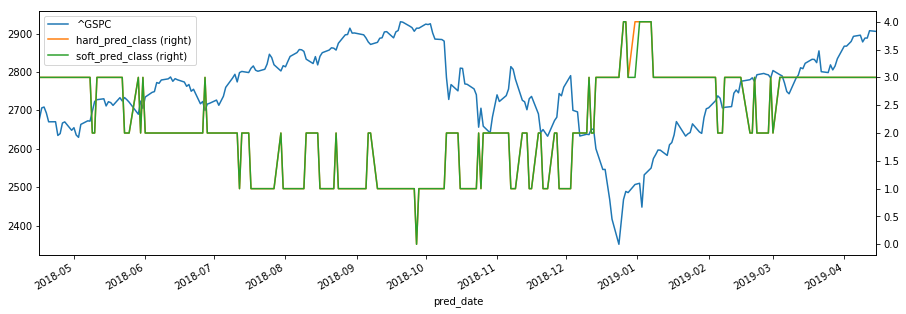

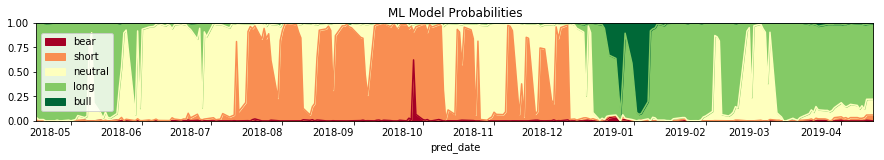

In [500]:
# Visualize macro predictions
pred_df = macro_df
pre_class_cols = filter_cols(pred_df.columns, "pred_class")
pred_df.loc[:,[bench] + pre_class_cols].plot(
    secondary_y=pre_class_cols, 
    figsize=(15, 5));
plt.savefig('../images/macro_chart.png', dpi=300, rot=0)
pred_df[fwd_ret_labels].plot.area(
        title='ML Model Probabilities',
        figsize=(15, 2), ylim=(0, 1), cmap='RdYlGn', rot=0);
f'Confidence Mean: {pred_df["soft_confidence"].mean().round(3)}, \
    Median {pred_df["soft_confidence"].median().round(3)}'
plt.savefig('../images/macro_prob.png', dpi=300)

### Bottom-up MLs

In [501]:
# Read ML predictions
fndm_dfs = {
    k: pd.read_csv(
        csv_load(f'{s3_path[k]}{tgt_date}'), 
        index_col='pred_date', 
        parse_dates=True)\
        for k in ('px_mom', 'fin_data', 'key_statistics', 
                  'eps_trend', 'eps_estimates', 'day_quote')
}
for key in fndm_dfs.keys(): 
    fndm_dfs[key].loc[:, 'model'] = key
    fndm_dfs[key] = fndm_dfs[key].loc[fndm_dfs[key].symbol.isin(eqty_symbols), :]

In [502]:
# turn into long format before pivoting
super_list = []
for key in fndm_dfs.keys():
    df = fndm_dfs[key]
    print(f'{key.upper()}, {df.symbol.shape[0]} unique symbols')
    super_list.append(df)
lf_df = pd.concat(super_list, axis=0)

PX_MOM, 1169 unique symbols
FIN_DATA, 1155 unique symbols
KEY_STATISTICS, 1167 unique symbols
EPS_TREND, 1200 unique symbols
EPS_ESTIMATES, 1200 unique symbols
DAY_QUOTE, 1224 unique symbols


model,px_mom,fin_data,key_statistics,eps_trend,eps_estimates,day_quote
soft_pred_label,,,,,,
bear,0.098,0.021,0.019,0.029,0.023,0.047
short,0.141,0.216,0.194,0.210,0.225,0.175
neutral,0.032,0.373,0.335,0.277,0.314,0.216
long,0.347,0.362,0.419,0.453,0.405,0.519
bull,0.382,0.028,0.033,0.032,0.033,0.044


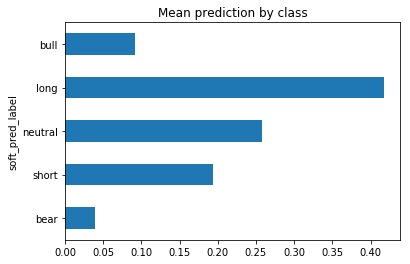

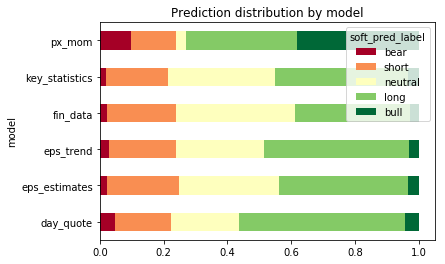

In [514]:
pvt_df = lf_df.pivot_table(
    index=['model'], columns=['soft_pred_label'], 
    values=['soft_confidence'], aggfunc='count')
class_distrib = pvt_df.div(pvt_df.sum(axis=1), axis=0)['soft_confidence'][fwd_ret_labels]
class_distrib.mean(axis=0).plot.barh(title='Mean prediction by class',);
plt.savefig('../images/ML_mean_weight.png', dpi=300, rot=0, bbox_inches='tight')
class_distrib.plot(title='Prediction distribution by model', kind='barh', stacked=True, cmap='RdYlGn');
plt.savefig('../images/ML_class_distrib.png', dpi=300, rot=0, bbox_inches='tight')
class_distrib.T[fndm_dfs.keys()]


#### ML weights

In [504]:
# Model score weights 
ml_score_dict = {
    'px_mom': 0.76, 'fin_data': 0.67, 'key_statistics': 0.71, 
    'eps_trend': 0.65, 'eps_estimates': 0.64, 
    'day_quote': 0.66, 
    'intrinsic_val': 0.7
}

cut_off_confidence = 0.6
model_scores = np.array(list(map(ml_score_dict.get, fndm_dfs.keys())))
adj_weights = (model_scores - cut_off_confidence) / (model_scores - cut_off_confidence).sum()
model_weights = pd.Series({x:y for x,y in zip(fndm_dfs.keys(), adj_weights)})

print('Model weights')
model_weights

Model weights


px_mom           0.327
fin_data         0.143
key_statistics   0.224
eps_trend        0.102
eps_estimates    0.082
day_quote        0.122
dtype: float64

### Filtered recomendations

In [505]:
# pivot and calculate weighted class and confidence
spc_df = lf_df.pivot_table(
    index=['symbol'], columns=['model'], 
    values=['soft_pred_class'], 
    aggfunc='mean')['soft_pred_class'][list(model_weights.index)]

wgt_class_df = (spc_df * model_weights.T).sum(axis=1)
wgt_conf_df = (lf_df.loc[:, ['symbol', 'soft_confidence', 'model']]\
    .pivot(index='symbol', columns='model', values='soft_confidence'
          ).loc[:, model_weights.index] * model_weights.T)\
    .sum(axis=1).sort_values()
wtg_df = pd.concat([wgt_class_df, wgt_conf_df], axis=1, sort=False)
wtg_df.columns = ['wtg_class', 'wtg_ML_prob']
wtg_df = add_desc_stats(wtg_df, descriptive_cols)

In [516]:
# long positions weighted class LONG or BULL
show = ['wtg_class','wtg_ML_prob','forwardPE', 
        'industry', 'targetMedianPrice', 'size']
L_df = wtg_df.loc[wtg_df.wtg_class > 3].sort_values(
    by='wtg_ML_prob', ascending=False).head(max_rows)
L_df[show]

,wtg_class,wtg_ML_prob,forwardPE,industry,targetMedianPrice,size
VIPS,3.327,0.762,10.141,Specialty Retail,0.886,mid
JD,3.327,0.684,31.892,Specialty Retail,0.979,large
HLT,3.327,0.633,20.555,Lodging,1.043,large
BAX,3.327,0.615,21.343,Medical Instruments & Supplies,1.005,large
WAT,3.327,0.602,23.485,Diagnostics & Research,0.940,large
VSM,3.327,0.601,20.542,Chemicals,0.904,mid
VRSK,3.327,0.582,28.018,Business Services,0.958,large
NFLX,3.327,0.578,54.854,Media - Diversified,1.190,large
MCO,3.327,0.577,21.506,Capital Markets,0.991,large
SBUX,3.327,0.570,25.053,Restaurants,0.919,large


In [517]:
# short positions weighted class BEAR or SHORT
S_df = wtg_df.loc[wtg_df.wtg_class < 1].sort_values(by='wtg_ML_prob', ascending=False).head(max_rows)
S_df[show]

,wtg_class,wtg_ML_prob,forwardPE,industry,targetMedianPrice,size
IPG,1.000,0.556,11.191,Advertising Agencies,1.163,mid
PENN,0.673,0.527,10.255,Resorts & Casinos,1.482,mid
MTB,1.000,0.519,10.741,Banks - Regional - US,1.087,large
ELY,0.796,0.504,14.591,Leisure,1.371,small
TTD,0.551,0.488,61.447,Software - Application,0.965,mid
SFM,0.918,0.488,15.940,Grocery Stores,1.124,mid
TX,0.918,0.488,5.835,Steel,1.284,mid
KT,0.673,0.472,6.000,Telecom Services,1.176,mid
ADNT,0.245,0.469,5.649,Auto Parts,0.695,mid
CTLT,0.673,0.456,21.777,Drug Manufacturers - Specialty & Generic,1.024,mid


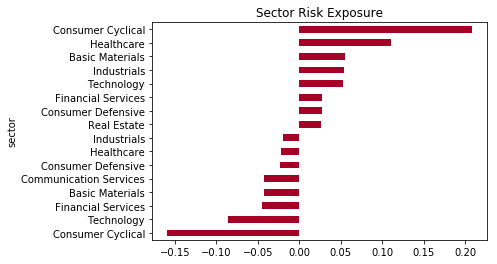

In [515]:
total_conf = pd.concat([L_df, S_df], axis=0).wtg_ML_prob.sum()
(L_df.groupby(by='sector').sum()['wtg_ML_prob'] / total_conf)\
    .append((S_df.groupby(by='sector').sum()['wtg_ML_prob'] / total_conf) * -1)\
    .sort_values().plot.barh(title='Sector Risk Exposure', cmap="RdYlGn")
plt.savefig('../images/ls_sector_exp.png', dpi=300, rot=0, bbox_inches='tight')

#### Company details

In [510]:
# Company view across models
ticker = 'VIPS'
show = [
    'hard_pred_label','soft_pred_label','soft_confidence',
    'bear', 'short', 'neutral', 'long', 'bull', 'model' ,'sector']
wgt_input = (ticker, 'soft_confidence')
print(f'Weighted ML score: {score_wgt_conf(wgt_input)}')
lf_df.loc[lf_df['symbol'] == '0700.HK', show]

Weighted ML score: 0.7615726491903483


/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,hard_pred_label,soft_pred_label,soft_confidence,bear,short,neutral,long,bull,model,sector
pred_date,,,,,,,,,,
2019-04-15,bull,bull,0.258,0.119,0.244,0.135,0.244,0.258,px_mom,nan
2019-04-15,long,long,0.424,0.215,0.115,0.145,0.424,0.101,fin_data,nan
2019-04-15,long,long,0.550,0.020,0.080,0.330,0.550,0.020,key_statistics,nan
2019-04-15,long,long,0.359,0.090,0.062,0.291,0.359,0.199,eps_trend,nan
2019-04-15,long,long,0.610,0.047,0.083,0.131,0.610,0.129,eps_estimates,nan
2019-04-15,bear,long,0.338,0.240,0.202,0.203,0.338,0.016,day_quote,nan


In [412]:
px_close = load_px_close('../tmp/', 'universe-px-ds', True).drop_duplicates()

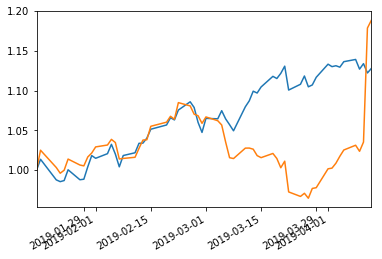

In [413]:
# backward looking performance of L/S recommendations
us_dts = px_close['^GSPC'].dropna()
get_ind_index(px_close.loc[us_dts.index, list(L_df.index)])['^IND'].plot()
get_ind_index(px_close.loc[us_dts.index, list(S_df.index)])['^IND'].plot()

### Universe Intrinsic Value Analysis

In [482]:
# Value companies in the universe
iv_show = ['premDisc', 'forwardPE', 'targetMedianPrice', 'pegRatio', 'growthRate']
iv_sizes = ['mega', 'large', 'mid']

iv_mask = (val_df.premDisc < 0.95) & (val_df.premDisc > 0)
iv_mapper = val_df.loc[iv_mask, 'premDisc']
iv_df = add_desc_stats(iv_mapper.to_frame(), descriptive_cols)
iv_df = iv_df.loc[iv_df['size'].isin(iv_sizes) & (iv_df.targetMedianPrice > 1.1), :]

iv_df.groupby(by=['sector', ]).agg(['count', 'min', 'median'])\
    .sort_values(by=(iv_show[0], 'median'))[iv_show]

premDisc              forwardPE                 \
                          count   min median     count     min median   
sector                                                                  
Financial Services           26 0.055  0.342        26   7.066 10.142   
Industrials                   9 0.101  0.523         9   5.946  8.070   
Basic Materials               5 0.406  0.639         5   5.833  7.211   
Communication Services        3 0.536  0.670         2   5.285  5.703   
Energy                        7 0.327  0.710         6   8.401 10.980   
Technology                    7 0.238  0.773         7   8.903 18.936   
Consumer Cyclical            12 0.281  0.797        12   6.306 10.430   
Utilities                     2 0.729  0.803         2   0.017  3.984   
Healthcare                    6 0.416  0.821         6 -14.060  9.829   
Consumer Defensive            2 0.827  0.864         2   8.552 12.235   

                       targetMedianPrice               pegRatio                \
                                   count   min  median    count    min median   
sector                                                                          
Financial Services                    26 1.100   1.123       26  0.163  0.913   
Industrials                            9 1.115   1.154        9  0.431  2.340   
Basic Materials                        5 1.185   1.241        5  0.625  1.010   
Communication Services                 3 1.152   1.303        2  0.566    inf   
Energy                                 7 1.126   1.194        6  0.219  1.272   
Technology                             7 1.104   1.138        7  0.097  0.776   
Consumer Cyclical                     12 1.105   1.172       12  0.477  1.573   
Utilities                              2 1.139 377.747        2  0.002    inf   
Healthcare                             6 1.164   1.300        6 -0.224  0.374   
Consumer Defensive                     2 1.123   1.124        2  1.801    inf   

                       growthRate               
                            count   min median  
sector                                          
Financial Services             26 0.000  0.117  
Industrials                     9 0.000  0.034  
Basic Materials                 5 0.050  0.070  
Communication Services          3 0.000  0.027  
Energy                          7 0.000  0.080  
Technology                      7 0.109  0.218  
Consumer Cyclical              12 0.000  0.059  
Utilities                       2 0.000  0.039  
Healthcare                      6 0.000  0.285  
Consumer Defensive              2 0.000  0.044

In [483]:
iv_df.loc[:, iv_show + ['sector', 'size']].sort_values(
    by=['size', 'premDisc', 'sector'], ascending=False).head(max_rows)

,premDisc,forwardPE,targetMedianPrice,pegRatio,growthRate,sector,size
symbol,,,,,,,
GOOGL,0.942,22.317,1.104,1.025,0.218,Technology,mega
GOOG,0.942,22.232,1.129,1.021,0.218,Technology,mega
FB,0.773,20.214,1.117,0.457,0.442,Technology,mega
BMY,0.942,10.266,1.251,0.394,0.261,Healthcare,large
WBA,0.900,8.552,1.123,inf,0.000,Consumer Defensive,large
REPYY,0.898,nan,2.208,nan,0.000,Energy,large
MCK,0.885,8.192,1.164,inf,0.000,Healthcare,large
COP,0.882,15.072,1.150,inf,0.000,Energy,large
TOT,0.878,8.932,1.260,1.494,0.060,Energy,large
